In [15]:
import pytest
import uuid
from typing import Generator, Union
from fnmatch import fnmatch

import networkx as nx
import matplotlib.pyplot as plt

from py_abac.storage.base import StorageBase
from py_abac import Policy
from py_abac.exceptions import PolicyExistsError

## In-Memory Storage

In [21]:
class InMemoryStorage(StorageBase):
    
    START_NODE = ("*", "*", "*")
    
    def __init__(self):
        self._index_map = {}
        self._targets_map = {
            self.START_NODE: []
        }
        self._targets_graph = nx.DiGraph()
        self._targets_graph.add_node(self.START_NODE)
        
    def add(self, policy: Policy):
        """
            Store a policy
        """
        target_ids = (
            policy.targets.subject_id,
            policy.targets.resource_id,
            policy.targets.action_id
        )
        
        # Add policy to index map
        if policy.uid in self._index_map:
            raise PolicyExistsError(policy.uid)
        self._index_map[policy.uid] = policy
        
        # Add policy UID to targets map
        if target_ids in self._targets_map:
            self._targets_map[target_ids].append(policy.uid)
        else:
            self._targets_map[target_ids] = [policy.uid]
            
        # TODO: Add target IDs to graph

    def get(self, uid: str) -> Union[None, Policy]:
        """
            Get specific policy
        """
        return self._index_map.get(uid, None)

    def get_all(self, limit: int, offset: int) -> Generator[Policy, None, None]:
        """
            Retrieve all the policies within a window
        """
        # Note: python by default sorts dict by key
        keys = self._index_map.keys()[offset:offset+limit]
        for key in keys:
            yield self._index_map[key]

    def get_for_target(
            self,
            subject_id: str,
            resource_id: str,
            action_id: str
    ) -> Generator[Policy, None, None]:
        """
            Get all policies for given target IDs.
        """
        # TODO: Get target IDs to check from graph for quicker lookup
        for target_ids in self._targets_map:
            match = all(
                fnmatch(target_ids[0], subject_id),
                fnmatch(target_ids[1], resource_id),
                fnmatch(target_ids[2], action_id),
            )
            if match:
                for policy in self._targets_map[target_ids]:
                    yield policy

    def update(self, policy: Policy):
        """
            Update a policy
        """
        if policy.uid not in self._index_map:
            raise ValueError("Policy with UID='{}' does not exist.".format(policy.uid))
        self._index_map[policy.uid] = policy

    def delete(self, uid: str):
        """
            Delete a policy
        """
        if uid not in self._index_map:
            raise ValueError("Policy with UID='{}' does not exist.".format(uid))
        
        # Remove policy UID from targets map
        policy = self._index_map[uid]
        target_ids = (
            policy.targets.subject_id,
            policy.targets.resource_id,
            policy.targets.action_id
        )
        self._targets_map[target_ids].remove(uid)
        # TODO: Remove target IDs index if collection of polcies is empty
        
        # Remove policy from index map
        del self._index_map[uid]


## Tests

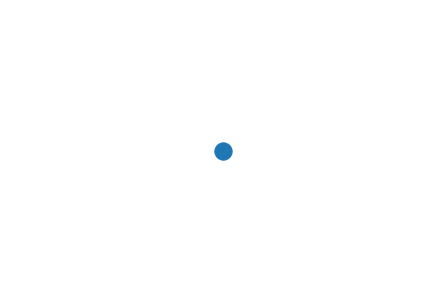

In [12]:
storage = InMemoryStorage()
nx.draw(storage._targets_graph)
plt.show()

In [5]:
@pytest.mark.parametrize("request_json, num", [
    ({
         "subject": {"id": "a"},
         "resource": {"id": str(uuid.uuid4())},
         "action": {"id": str(uuid.uuid4())}
     }, 1),
    ({
         "subject": {"id": "ab"},
         "resource": {"id": str(uuid.uuid4())},
         "action": {"id": str(uuid.uuid4())}
     }, 3),
    ({
         "subject": {"id": "abc"},
         "resource": {"id": str(uuid.uuid4())},
         "action": {"id": str(uuid.uuid4())}
     }, 3),
    ({
         "subject": {"id": "acb"},
         "resource": {"id": str(uuid.uuid4())},
         "action": {"id": str(uuid.uuid4())}
     }, 2),
    ({
         "subject": {"id": "axc"},
         "resource": {"id": str(uuid.uuid4())},
         "action": {"id": str(uuid.uuid4())}
     }, 1),
])
def test_find_for_target(st, request_json, num):
    st.add(Policy.from_json({"uid": "1",
                             "rules": {},
                             "targets": {},
                             "effect": "deny"}))
    st.add(Policy.from_json({"uid": "2",
                             "rules": {},
                             "targets": {"subject_id": "ab*"},
                             "effect": "deny"}))
    st.add(Policy.from_json({"uid": "3",
                             "rules": {},
                             "targets": {"subject_id": "a*b"},
                             "effect": "deny"}))
    st.add(Policy.from_json({"uid": "4",
                             "rules": {},
                             "targets": {"subject_id": "ab*c"},
                             "effect": "deny"}))

    request = AccessRequest.from_json(request_json)
    found = st.get_for_target(request._subject_id, request._resource_id, request._action_id)
    found = list(found)
    assert num == len(found)

In [17]:
a = ["1", "d"]

In [18]:
a.remove("d")

In [19]:
a

['1']

In [20]:
a.remove("c")

ValueError: list.remove(x): x not in list